<a href="https://colab.research.google.com/github/pedrocamargo99/sao-paulo-daily-temperature-regression/blob/main/exploratory_analysis_sao_paulo_daily_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Download latest version
path = kagglehub.dataset_download("sudalairajkumar/daily-temperature-of-major-cities")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sudalairajkumar/daily-temperature-of-major-cities/versions/1


In [34]:
df = pd.read_csv(path + "/city_temperature.csv")
df.head()
display(df.info())

<ipython-input-34-d90ddde69d78>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/city_temperature.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


None

In [35]:
#Dataset format
print("Dataset format:", df.shape)

Dataset format: (2906327, 8)


In [36]:
#Filtered only the data from the city São Paulo and reset the index column
df_sao_paulo = df[df["City"] == "Sao Paulo"].reset_index(drop=True)

#Dropped location identification columns
df=df_sao_paulo.drop(['Region','Country','State','City'], axis=1)
display(df)

,Month,Day,Year,AvgTemperature
0,1,1,1995,71.8
1,1,2,1995,73.5
2,1,3,1995,72.7
3,1,4,1995,72.7
4,1,5,1995,75.3
...,...,...,...,...
9261,5,9,2020,61.7
9262,5,10,2020,63.7
9263,5,11,2020,65.9
9264,5,12,2020,66.8


In [37]:
#New Dataset Format
df.shape

(9266, 4)

In [38]:
#Checking for Null Values
df.info()

#Describe Values
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9266 entries, 0 to 9265
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Month           9266 non-null   int64  
 1   Day             9266 non-null   int64  
 2   Year            9266 non-null   int64  
 3   AvgTemperature  9266 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 289.7 KB


,Month,Day,Year,AvgTemperature
count,9266.000000,9266.000000,9266.000000,9266.000000
mean,6.468919,15.717354,2007.188215,66.832797
std,3.457327,8.801516,7.325356,17.743093
min,1.000000,1.000000,1995.000000,-99.000000
25%,3.000000,8.000000,2001.000000,64.000000
50%,6.000000,16.000000,2007.000000,68.800000
75%,9.000000,23.000000,2014.000000,73.100000
max,12.000000,31.000000,2020.000000,89.200000


In [39]:
#Checking if there is data for every day on every year of the dataset
for year in df["Year"].unique():
    print(year, df[df["Year"] == year].shape[0])

1995 365
1996 366
1997 365
1998 365
1999 365
2000 366
2001 365
2002 365
2003 365
2004 366
2005 365
2006 365
2007 365
2008 366
2009 365
2010 365
2011 365
2012 366
2013 365
2014 365
2015 366
2016 366
2017 365
2018 365
2019 365
2020 134


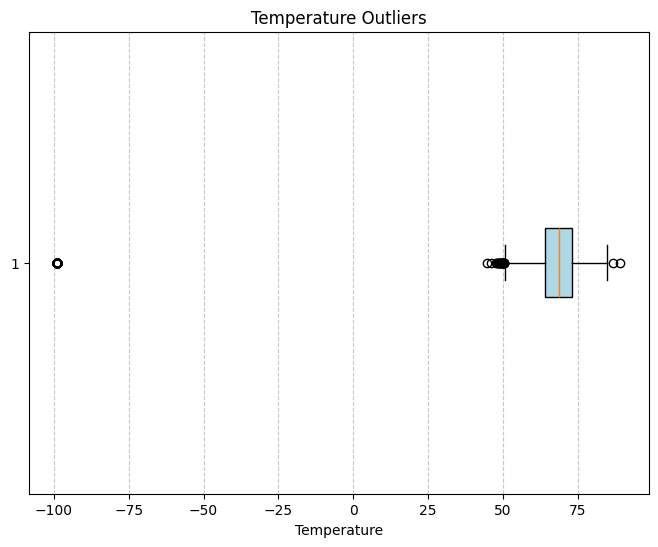

In [40]:
#Boxplot checking for outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df['AvgTemperature'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Temperature Outliers')
plt.xlabel('Temperature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [41]:
# Calculate Q1, Q3 e IQR
Q1 = df['AvgTemperature'].quantile(0.25)
Q3 = df['AvgTemperature'].quantile(0.75)
IQR = Q3 - Q1

# Define limits
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['AvgTemperature'] < limite_inferior) | (df['AvgTemperature'] > limite_superior)]
print("Outliers encontrados:")
display(outliers)

Outliers encontrados:


,Month,Day,Year,AvgTemperature
568,7,22,1996,48.5
1017,10,14,1997,-99.0
1018,10,15,1997,-99.0
1024,10,21,1997,-99.0
1028,10,25,1997,-99.0
...,...,...,...,...
8903,5,17,2019,-99.0
8904,5,18,2019,-99.0
8905,5,19,2019,-99.0
8953,7,6,2019,50.0


In [42]:
#Switching Outliers values to mean value
mean = (df[df['AvgTemperature'] != -99])['AvgTemperature'].mean()
print("Mean:", mean)
df['AvgTemperature'] = df['AvgTemperature'].replace(-99, mean)
print("Outliers switched to mean:")
display(df)
df.describe()

Mean: 68.49582515805538
Outliers switched to mean:


,Month,Day,Year,AvgTemperature
0,1,1,1995,71.8
1,1,2,1995,73.5
2,1,3,1995,72.7
3,1,4,1995,72.7
4,1,5,1995,75.3
...,...,...,...,...
9261,5,9,2020,61.7
9262,5,10,2020,63.7
9263,5,11,2020,65.9
9264,5,12,2020,66.8


,Month,Day,Year,AvgTemperature
count,9266.000000,9266.000000,9266.000000,9266.000000
mean,6.468919,15.717354,2007.188215,68.495825
std,3.457327,8.801516,7.325356,6.245240
min,1.000000,1.000000,1995.000000,44.800000
25%,3.000000,8.000000,2001.000000,64.300000
50%,6.000000,16.000000,2007.000000,68.800000
75%,9.000000,23.000000,2014.000000,73.100000
max,12.000000,31.000000,2020.000000,89.200000


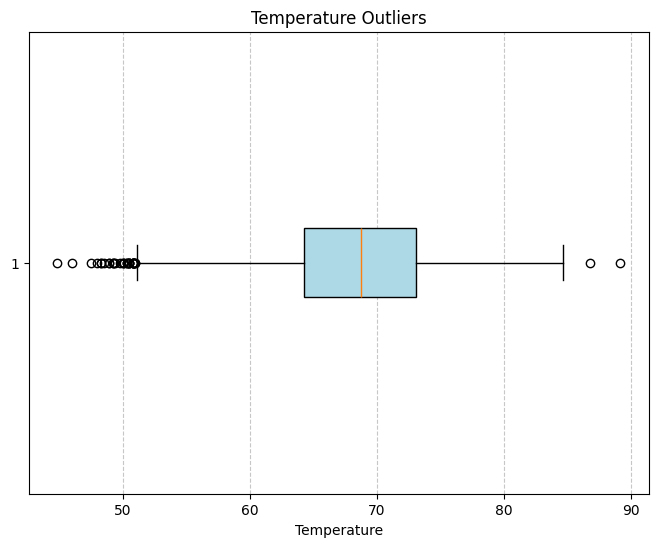

In [43]:
#New Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df['AvgTemperature'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Temperature Outliers')
plt.xlabel('Temperature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Estatística ADF: -2.628413443742876
P-valor: 0.08726581856592874


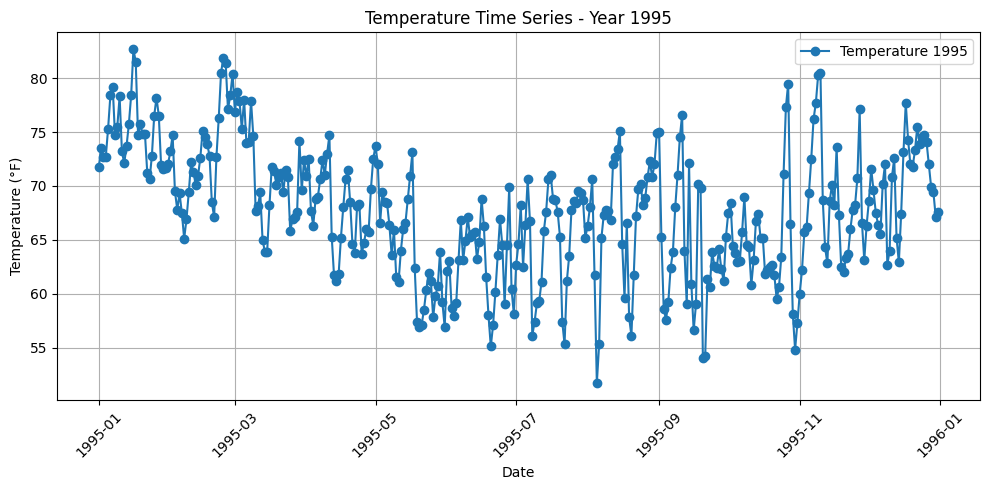

Estatística ADF: -2.0237480549816054
P-valor: 0.2762584452558843


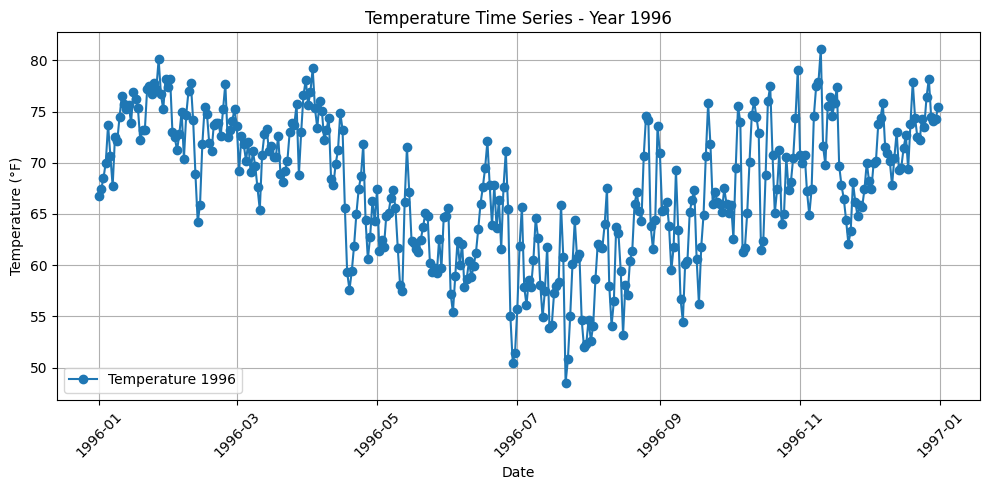

Estatística ADF: -2.234430402566916
P-valor: 0.19398730137333736


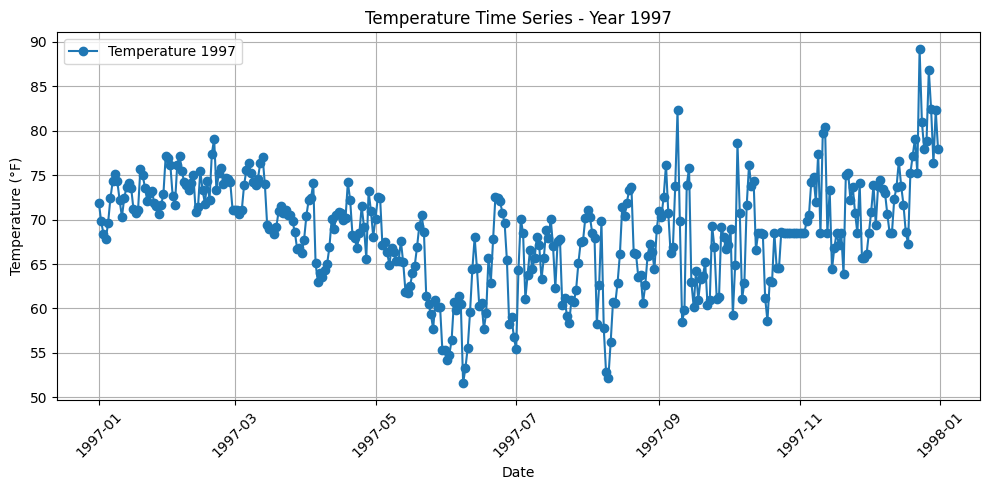

Estatística ADF: -3.132349045330971
P-valor: 0.024250007463358775


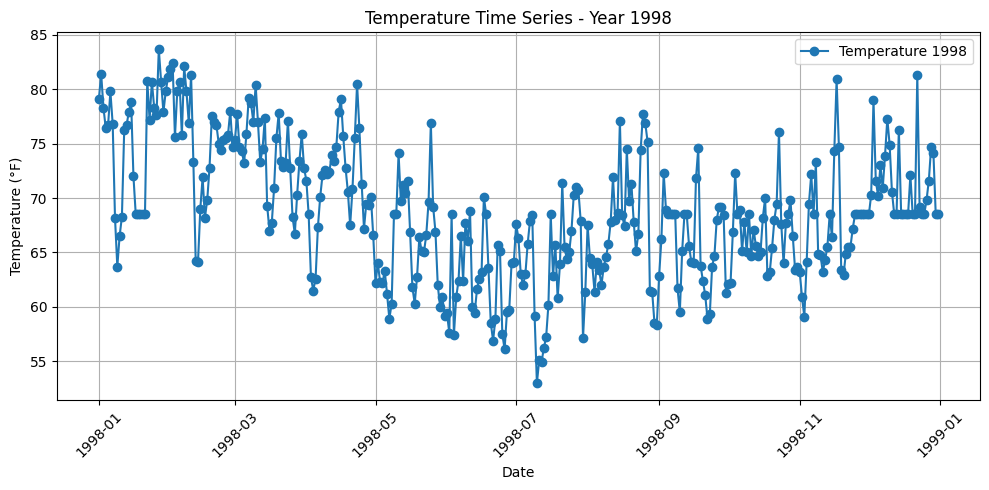

Estatística ADF: -3.1084283032174103
P-valor: 0.025935711261128064


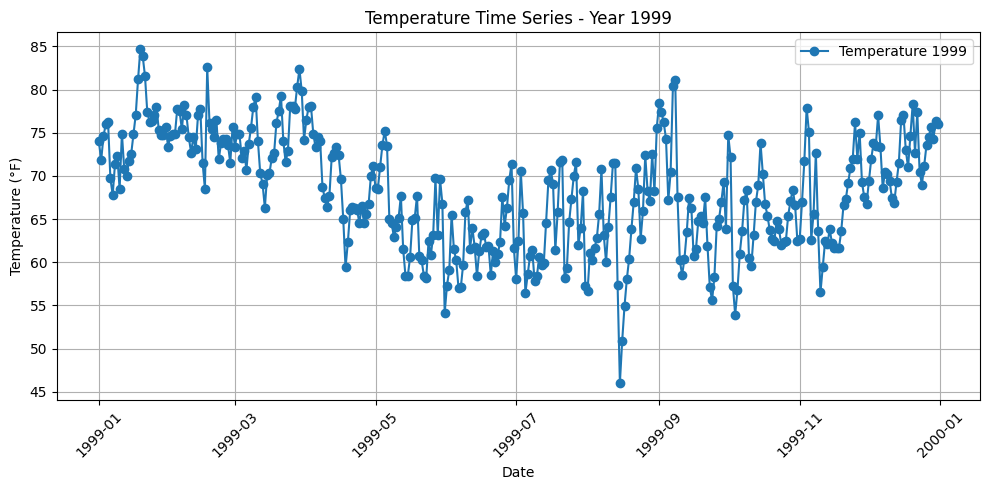

Estatística ADF: -4.072596257035536
P-valor: 0.001074621700927364


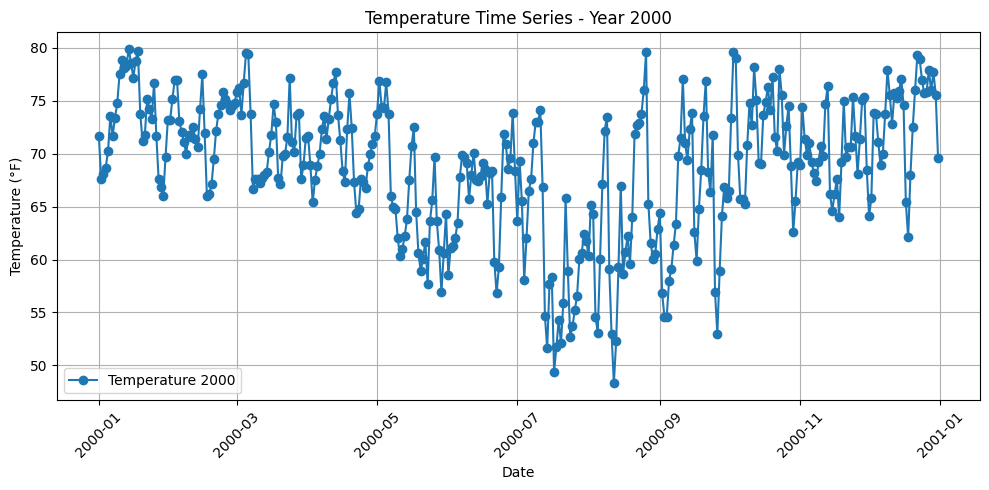

Estatística ADF: -2.6700190085423654
P-valor: 0.07937151974196888


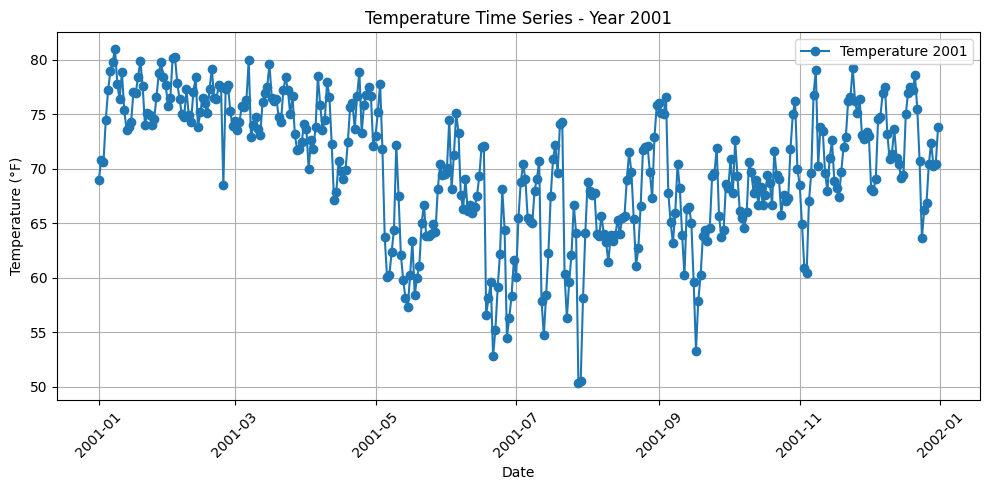

Estatística ADF: -3.3798740785280037
P-valor: 0.011664398138127537


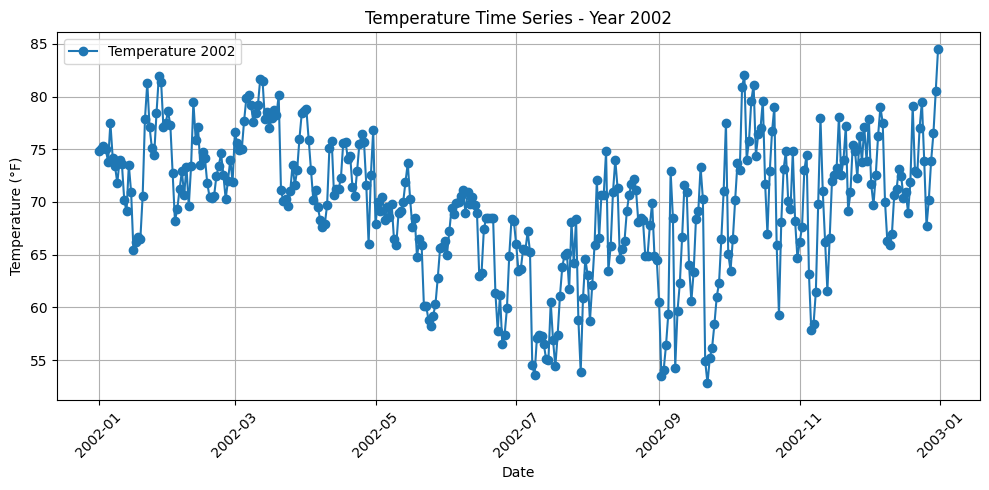

Estatística ADF: -1.8316908800561418
P-valor: 0.3648453869884706


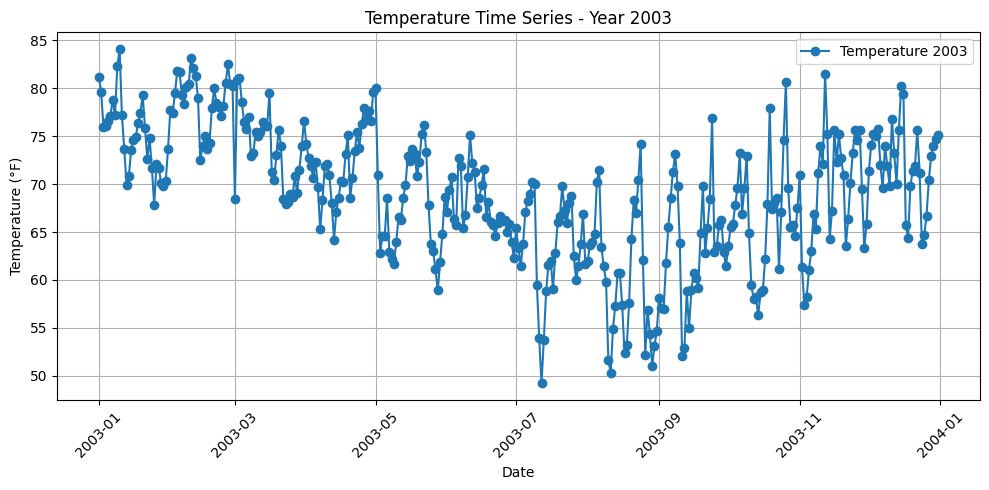

Estatística ADF: -4.20590298275125
P-valor: 0.0006439031290477367


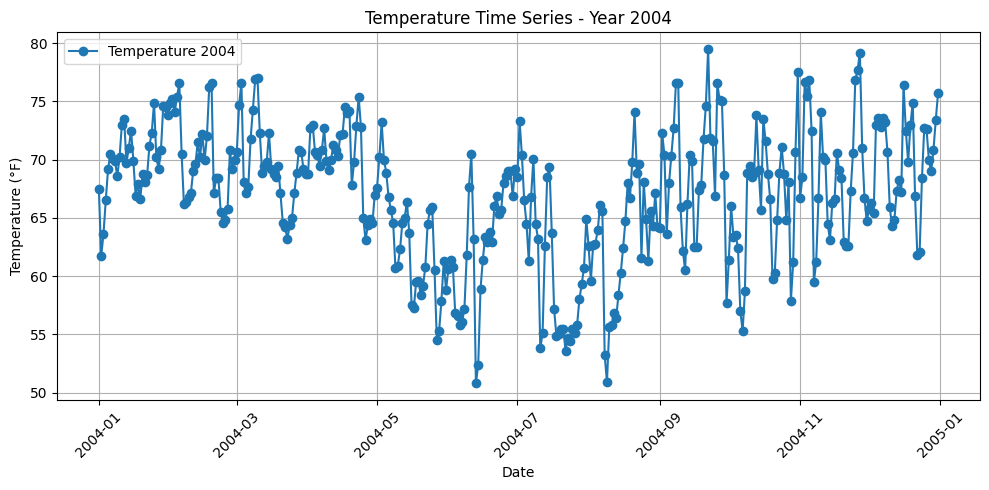

Estatística ADF: -5.732152900477012
P-valor: 6.562485545722382e-07


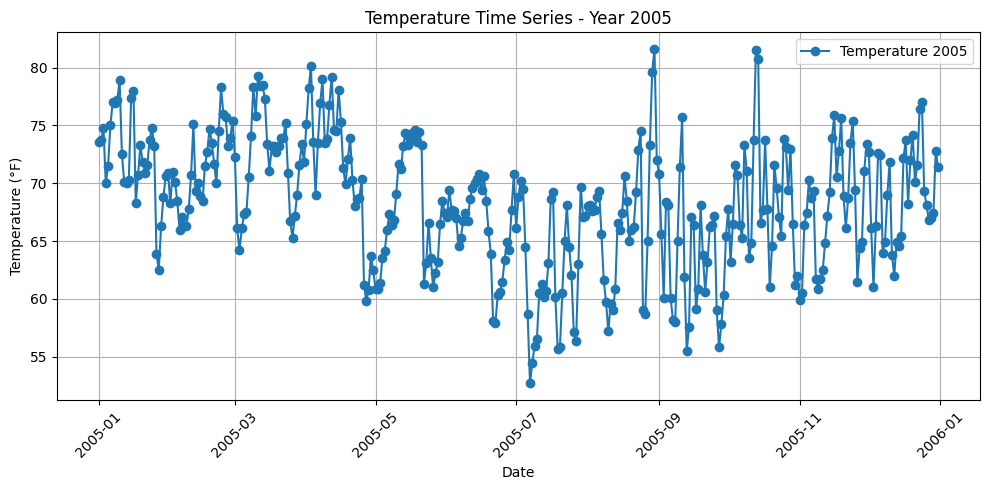

Estatística ADF: -1.6342001580430392
P-valor: 0.46529295736124987


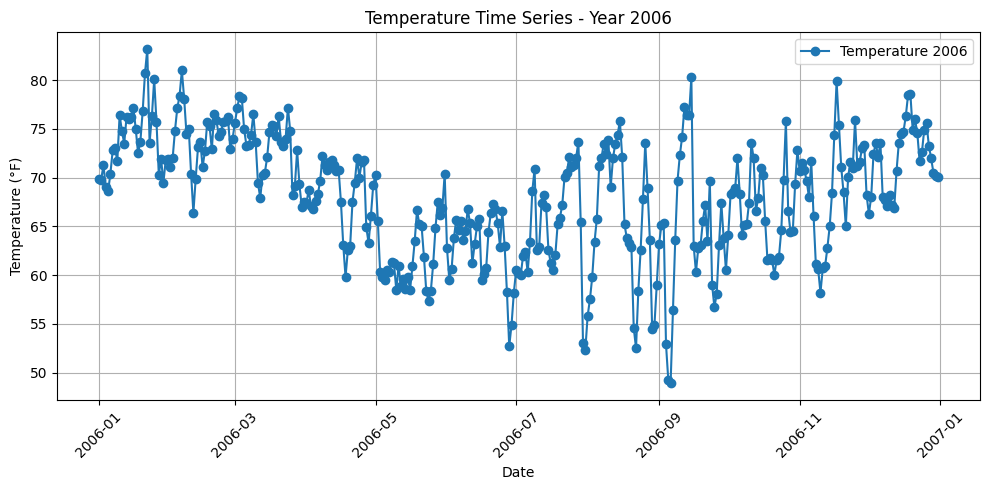

Estatística ADF: -5.190784873817027
P-valor: 9.181045612888203e-06


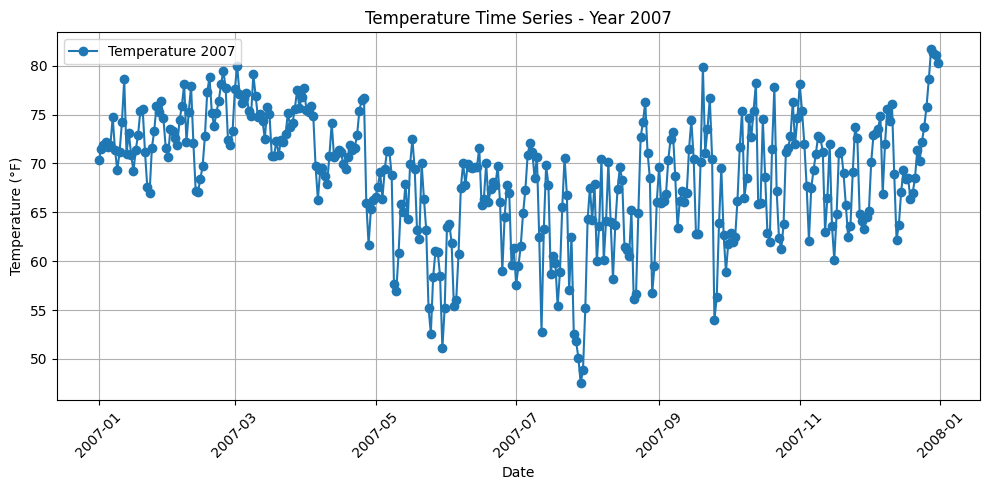

Estatística ADF: -4.101537615546285
P-valor: 0.0009628720194829954


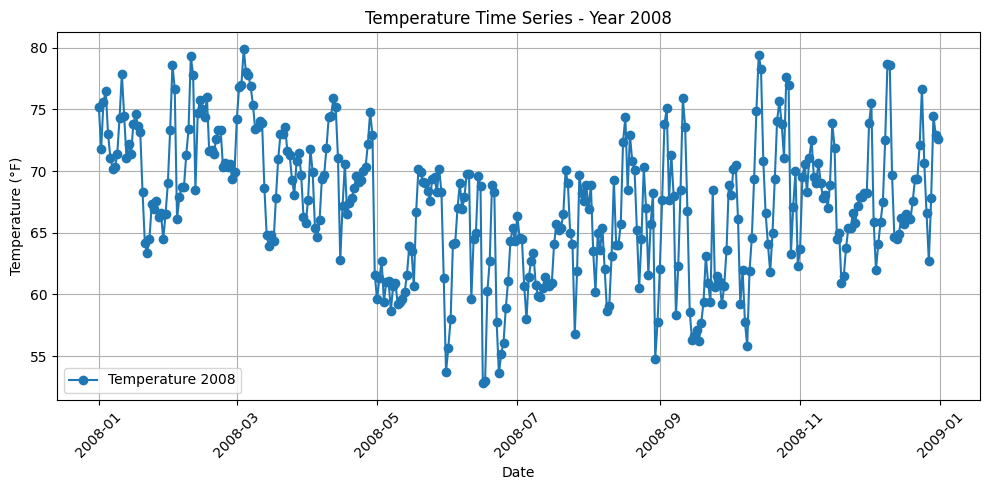

Estatística ADF: -2.6518637754196774
P-valor: 0.08274468887519171


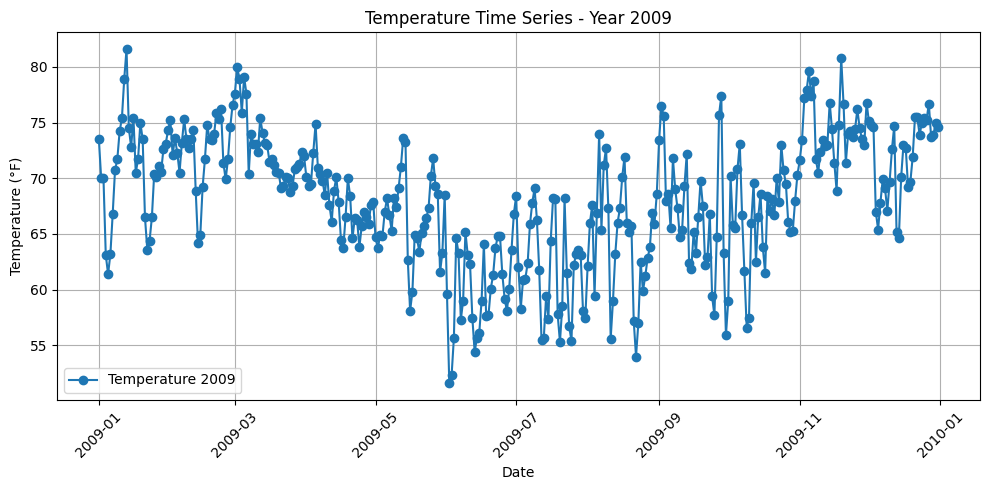

Estatística ADF: -3.0937878494717004
P-valor: 0.027016344218541186


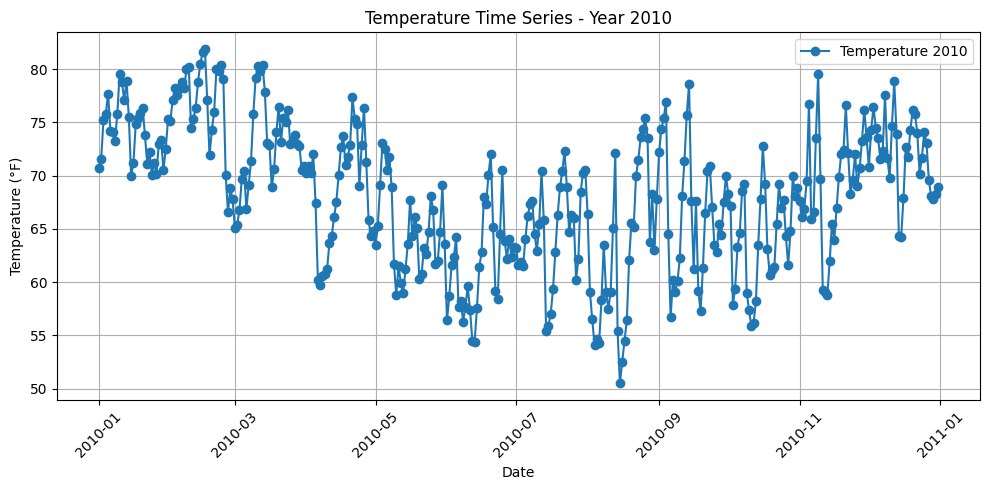

Estatística ADF: -1.9287182626871104
P-valor: 0.31867404688877476


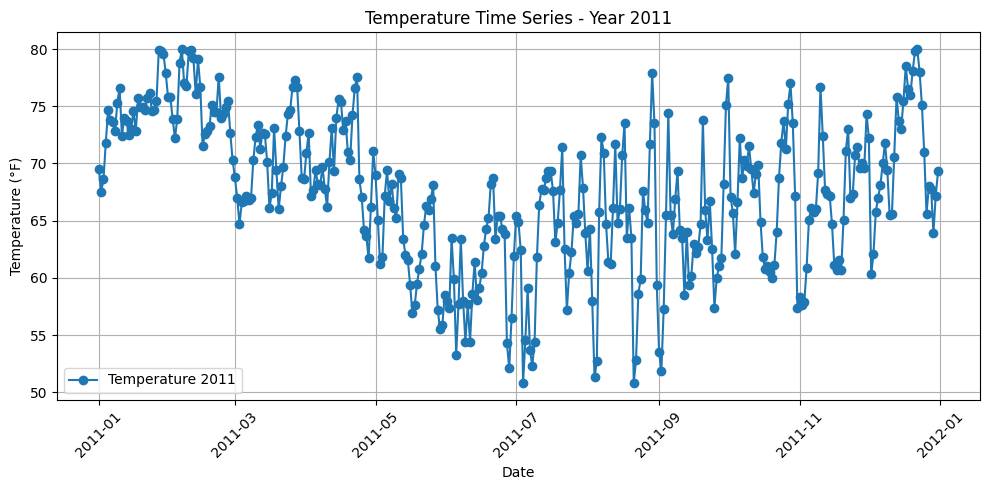

Estatística ADF: -4.407553650389446
P-valor: 0.0002878278930178534


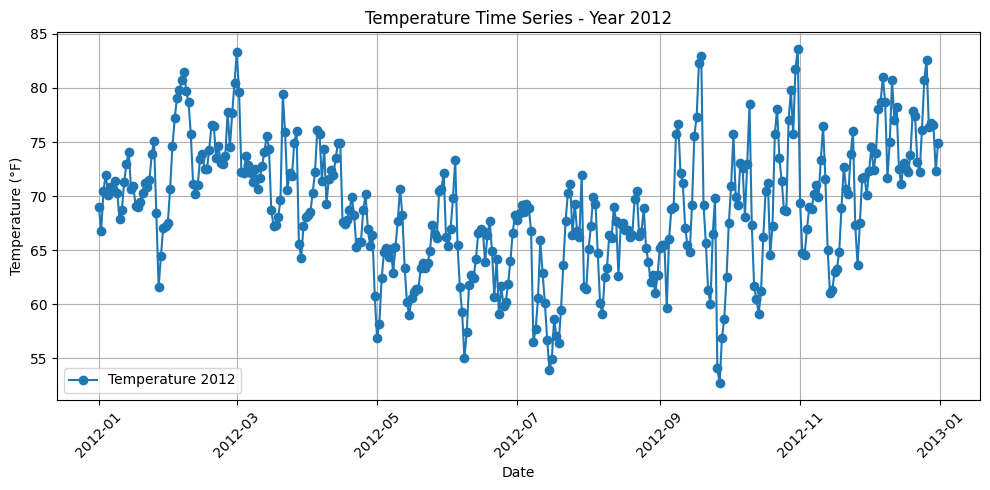

Estatística ADF: -3.6404161299372304
P-valor: 0.005033740968418611


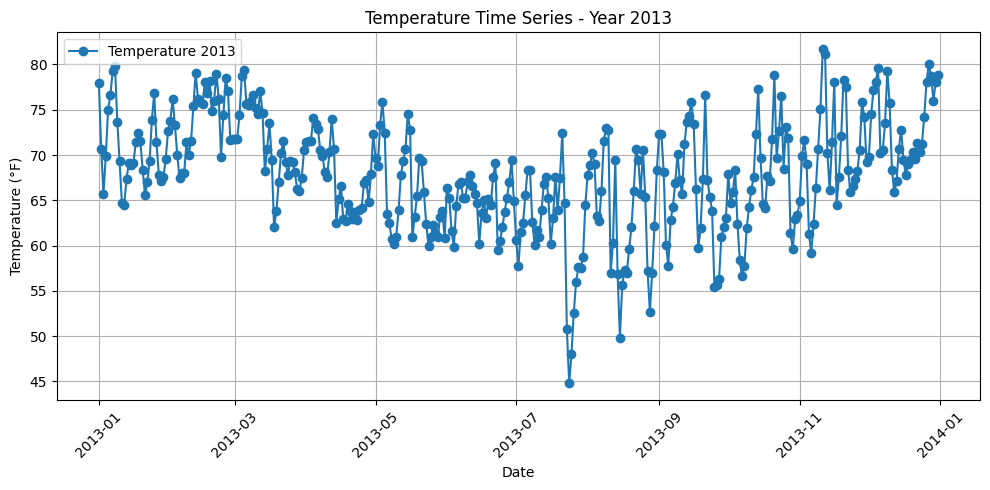

Estatística ADF: -3.9870069438223523
P-valor: 0.0014800958716951378


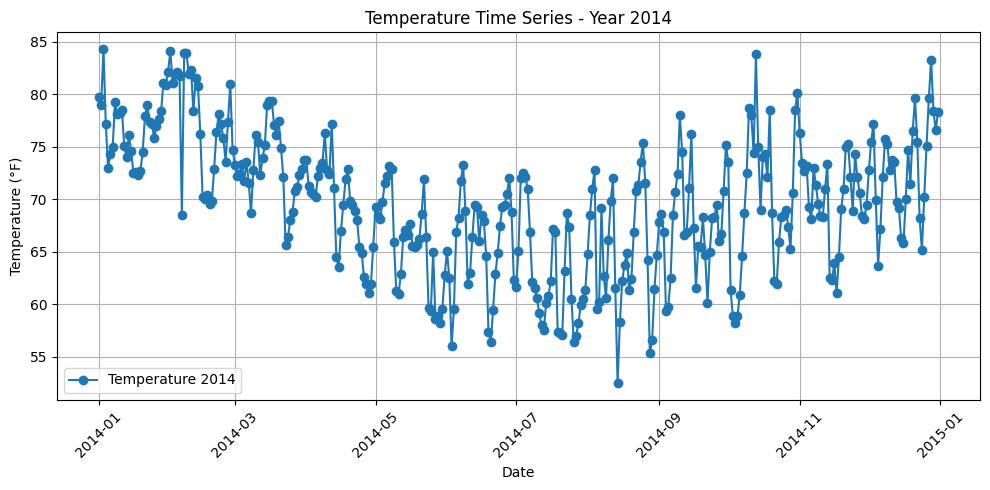

Estatística ADF: -3.9212442003419072
P-valor: 0.0018839467881083588


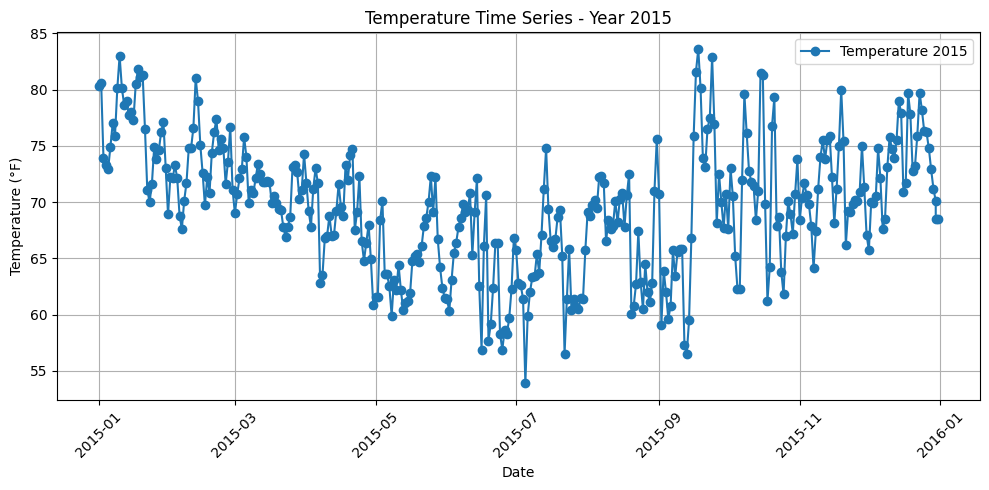

Estatística ADF: -1.9558638008315385
P-valor: 0.30625405395240257


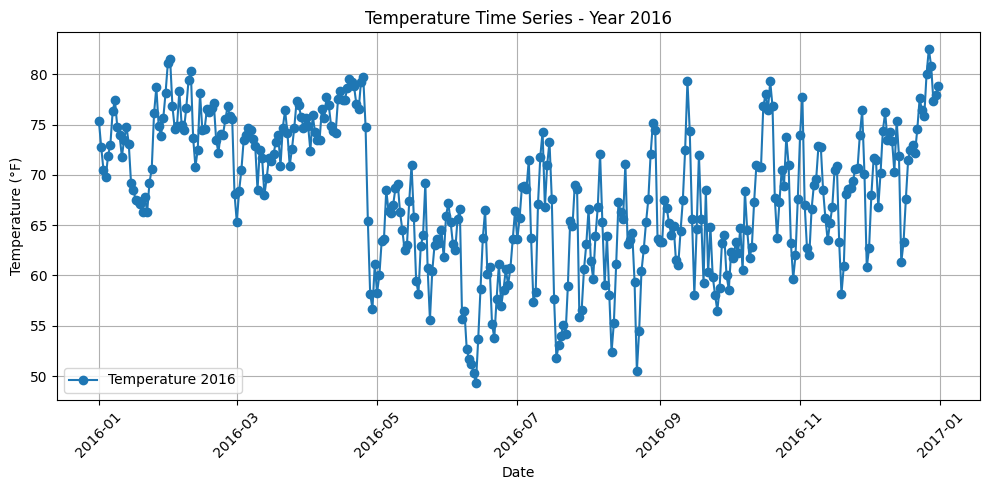

Estatística ADF: -2.7314098256665407
P-valor: 0.06875891261011124


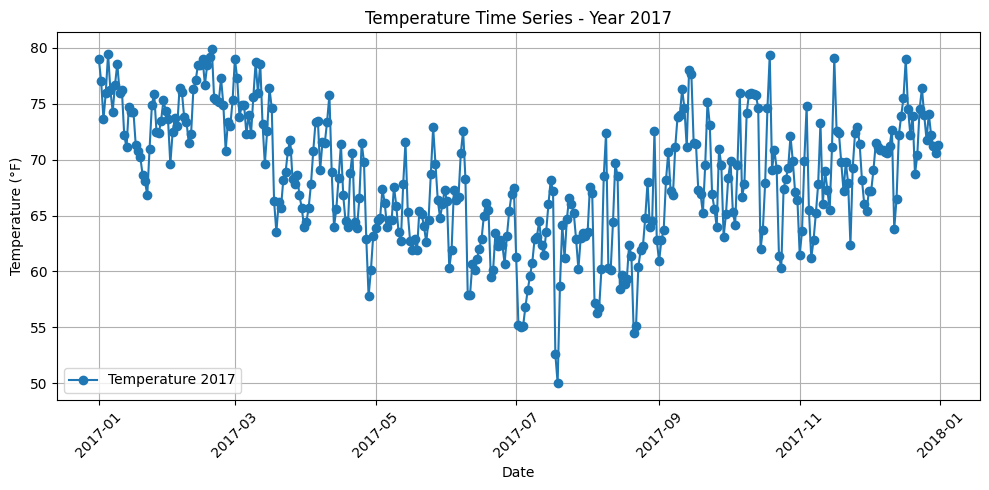

Estatística ADF: -2.520440790291997
P-valor: 0.11057974109067287


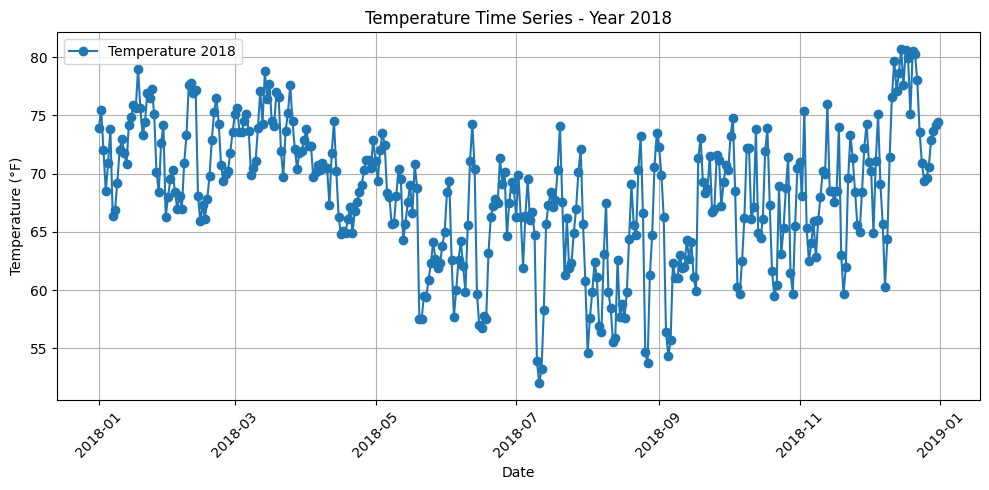

Estatística ADF: -3.232114094758264
P-valor: 0.018199436264762652


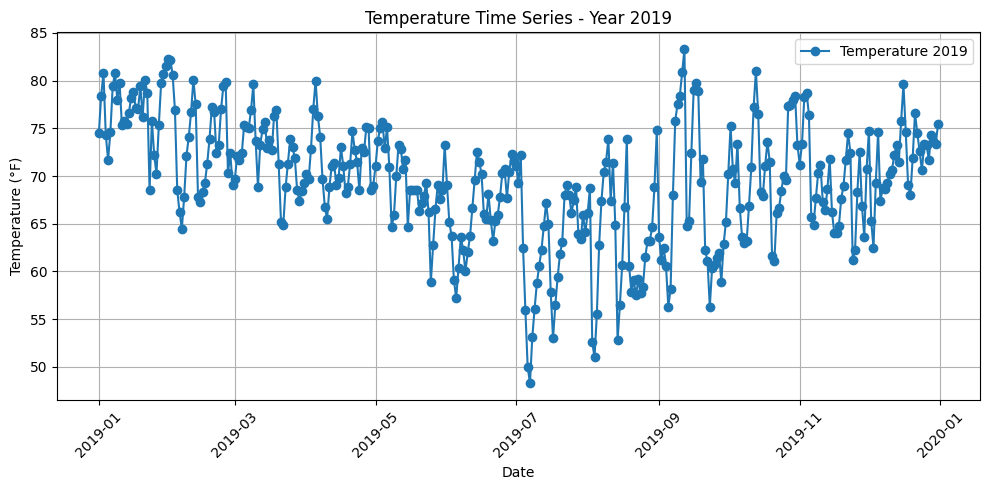

Estatística ADF: -3.0762837794870737
P-valor: 0.02835880930402233


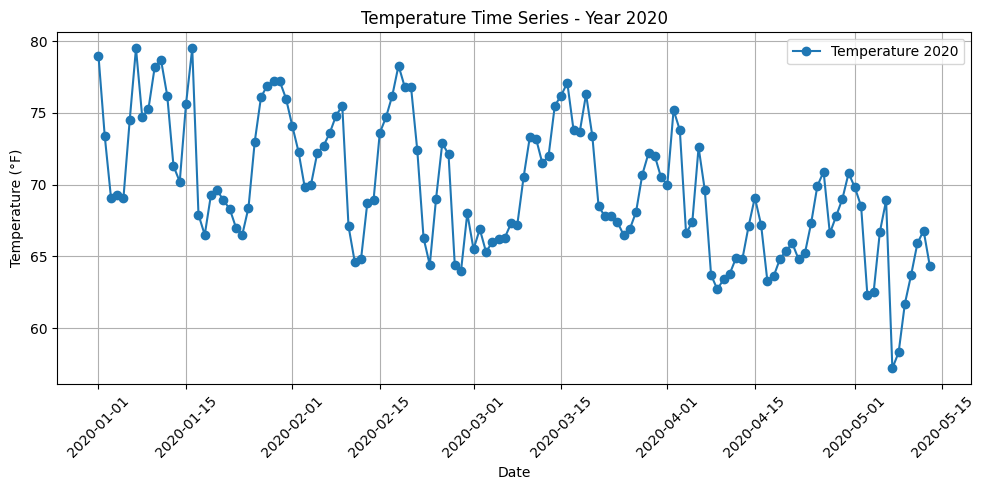

In [44]:
# Creating Date Column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

#Time Series per Year
for year in df["Year"].unique():
  # Order by date
  df_ano = df[df['Year'] == year]

  result = adfuller(df_ano['AvgTemperature'])
  print(f"Estatística ADF: {result[0]}")
  print(f"P-valor: {result[1]}")

  plt.figure(figsize=(10, 5))
  plt.plot(df_ano['Date'], df_ano['AvgTemperature'], marker='o', linestyle='-', label=f'Temperature {year}')
  plt.title(f'Temperature Time Series - Year {year}')
  plt.xlabel('Date')
  plt.ylabel('Temperature (°F)')
  plt.grid(True)
  plt.legend()
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

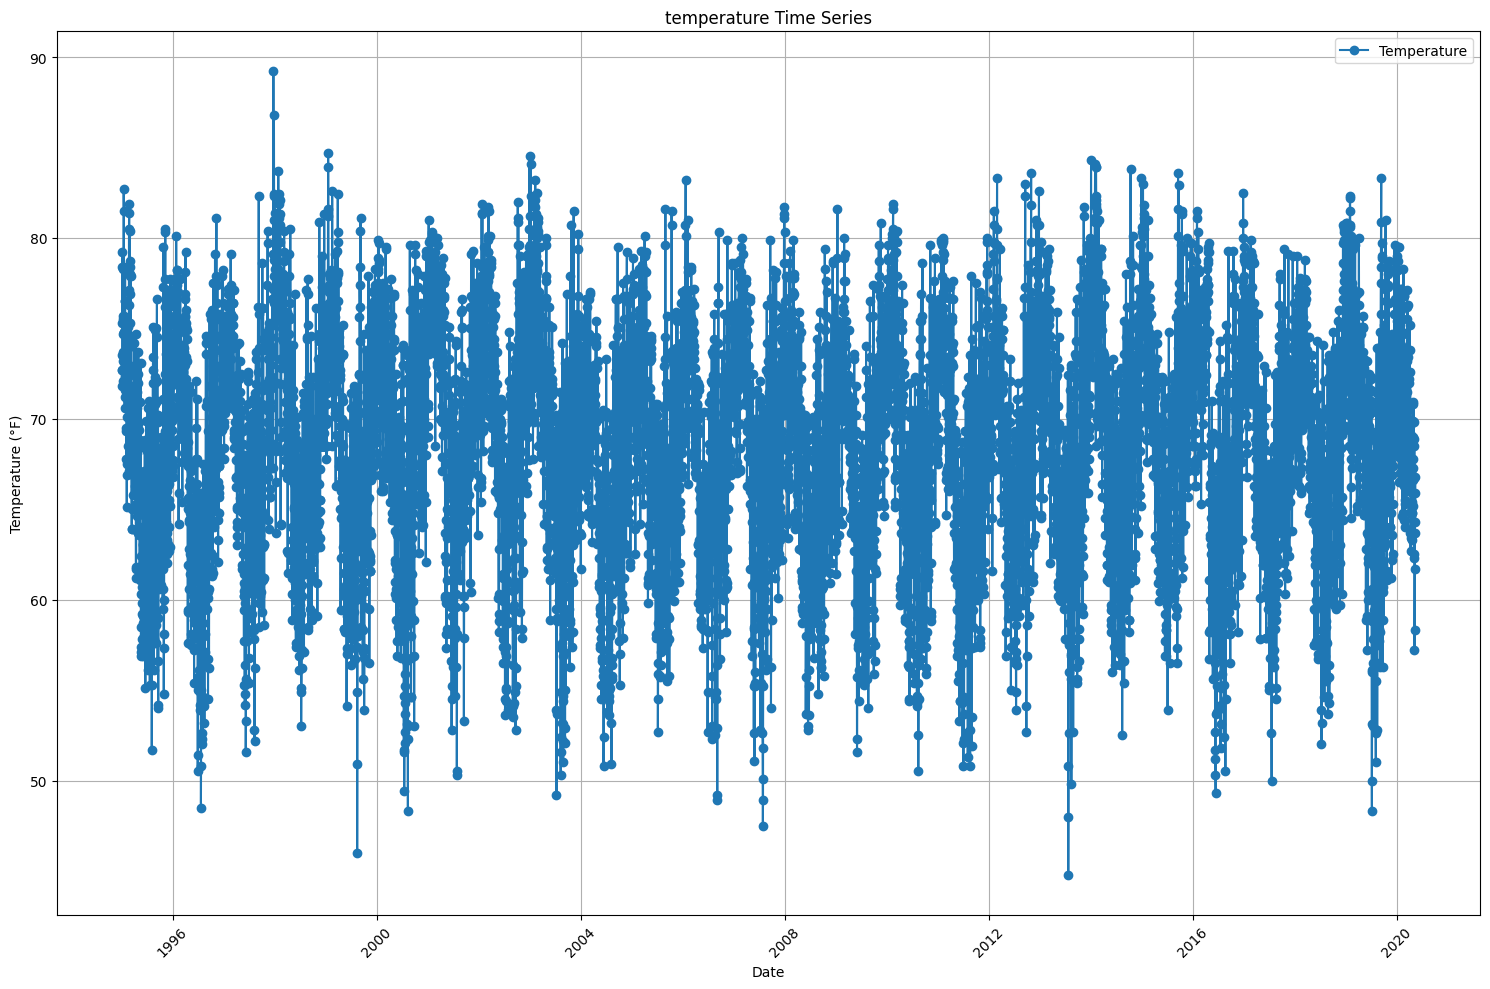

In [45]:
# Time Series all years
plt.figure(figsize=(15, 10))
plt.plot(df['Date'], df['AvgTemperature'], marker='o', linestyle='-', label='Temperature')
plt.title('temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

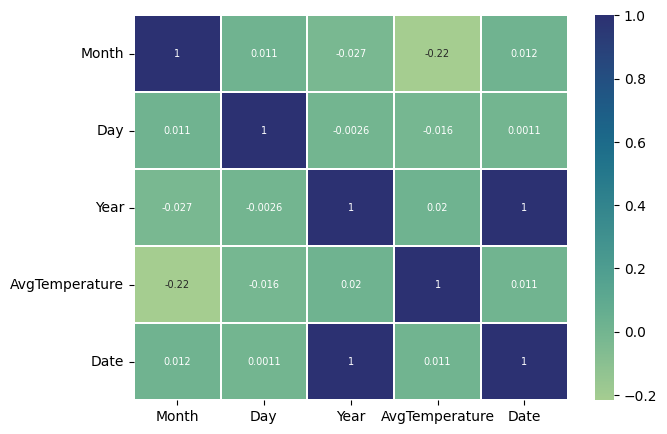

In [46]:
# Correlation Diagram
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(),linewidths=.1,cmap="crest", annot=True, annot_kws={"size": 7})
plt.yticks(rotation=0);
#plt.savefig("corr.png", format='png', dpi=400, bbox_inches='tight')

In [47]:
df.to_csv('sao-paulo-daily-temperature.csv', index=False)